# Setting

In [1]:
import FinanceDataReader as fdr
import pandas as pd

from pf_utils import convert_rate_to_price
from pf_utils import BacktestManager, get_date_range, AssetEvaluator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## testing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import bt
from pf_custom import SelectKRatio

import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

metrics = [
    'total_return', 'cagr', 'calmar', 
    'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 
    'daily_vol', 'daily_sharpe', 'daily_sortino', 
    'monthly_vol', 'monthly_sharpe', 'monthly_sortino'
]

WEEKS_IN_YEAR = 51


def import_rate1(file, path='.', cols=['date', None]):
    """
    file: historical of cumulative rate of return in long format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}', parse_dates=[0], index_col=[0])
    if df_rate.columns.size > 1:
        print('WARNING: taking the 1st two columns only.')
    # make sure to get series
    df_rate = df_rate.iloc[:, 0]
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate


def import_rate2(file, path='.', cols=['date', None], n_headers=1):
    """
    file: historical of cumulative rate of return in wide format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}')
    df_rate = df_rate.T.iloc[n_headers:, 0]

    df_rate.index = pd.to_datetime(df_rate.index)
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate
    

def get_price(df_rate, data_check, rate_is_percent=True):
    """
    calc price from rate of return
    """
    # date check
    for dt, _ in data_check:
        try:
            dt = pd.to_datetime(dt)
            rate = df_rate.loc[dt]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
    
    # convert to price with data_check[0]
    dt, price = data_check[0]
    dt = pd.to_datetime(dt)
    rate = df_rate.loc[dt]
    if rate_is_percent:
        rate = rate/100
        df_rate = df_rate/100
    price_base = price / (rate+1)
    df_price = (df_rate + 1) * price_base 

    # check price
    dt, price = data_check[1]
    e = df_price.loc[dt]/price - 1
    print(f'error: {e*100:.2f} %')
    
    return df_price


def convert_rate_to_price(data, n_headers=1, path=None, 
                          rate_is_percent=True, df_rate=None, rate_only=False):
    """
    data: series or dict
    df_rate: historical given as dataframe
    """
    data_type = data['data_type']
    if data_type == 1:
        import_rate = import_rate1
    elif data_type == 2:
        import_rate = lambda *args, **kwargs: import_rate2(*args, n_headers=n_headers, **kwargs)
    else:
        if df_rate is None:
            return print(f'ERROR: no data type {data_type} exists')
        else:
            import_rate = lambda *args, **kwargs: df_rate.rename_axis(kwargs['cols'][0]).rename(kwargs['cols'][1])
    
    ticker = data['ticker']
    name = data['name']
    file = f'{data['file']}.csv'
    data_check = [
        (data['check1_date'], data['check1_price']),
        (data['check2_date'], data['check2_price']),
    ]
    
    df = import_rate(file, path=path, cols=['date', ticker])
    if rate_only:
       return df
        
    df = get_price(df, data_check, rate_is_percent=rate_is_percent)
    if df is None:
        return print(f'ERROR: check {ticker}')
    else:
        return df


def get_date_range(dfs, symbol_name=None, slice_input=False):
    """
    symbol_name: dict of symbols to names
    """
    df = dfs.apply(lambda x: x[x.notna()].index.min()).to_frame('start date')
    df = df.join(dfs.apply(lambda x: x[x.notna()].index.max()).to_frame('end date'))
    if symbol_name is not None:
        df = pd.Series(symbol_name).to_frame('name').join(df)

    if slice_input:
        start_date = df.iloc[:, 0].max()
        end_date = df.iloc[:, 1].min()
        return dfs.loc[start_date:end_date]
    else:
        return df.sort_values('start date')



def valuate_bond(face, rate, year, ytm, n_pay=1):
    """
    face: face value
    rate: coupon rate (annual)
    year: years to maturity
    ytm: discount rate (annual)
    n_pay: number of payments per year
    """
    c = face * rate / n_pay
    vc = 0
    r_discount = ytm/n_pay
    # calc The present value of expected cash flows
    for t in range(1, year*n_pay+1):
        vc += c/(1+r_discount)**t
    # the present value of the face value of the bond added
    return vc + face/(1+r_discount)**(year*n_pay)
        




### class

### test

# Data

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [4]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')

In [5]:
tdf_names = df_info.set_index('ticker')['name'].to_dict()
commissions = df_info.set_index('ticker')['commission'].to_dict()
{tdf_names[k]:v for k,v in commissions.items()}

{'미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e': 0.6,
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.48,
 '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e': 0.54,
 '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e': 0.74,
 '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.68,
 'KODEX 미국S&P500TR assumed from S&P500 rate of return': 0.0}

In [6]:
df_info = df_info.iloc[:-1]
df_tdfs = None

for _, data in df_info.iterrows():
    df = convert_rate_to_price(data, path=path_data)
    
    if df_tdfs is None:
        df_tdfs = df.to_frame()
    else:
        df_tdfs = df_tdfs.join(df, how='outer')

error: -0.07 %
error: -0.00 %
error: 0.16 %
error: -0.13 %
error: 0.00 %


In [7]:
get_date_range(df_tdfs)

,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-06-16
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-06-13


<Axes: xlabel='date'>

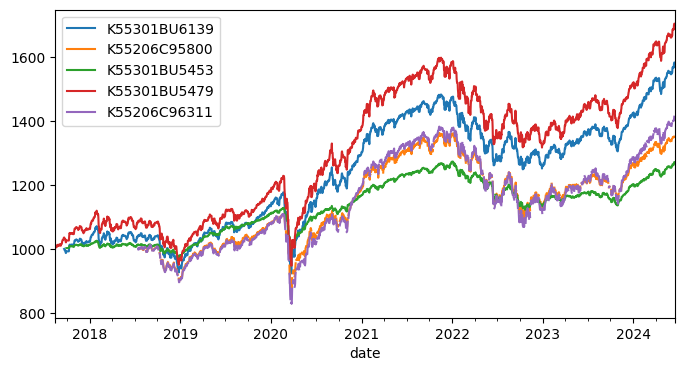

In [8]:
df_tdfs.plot(figsize=(8,4))

## ETF

In [9]:
file = 'etfs_selected_240611.csv'
df_etfs = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etfs.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etfs.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [11]:
get_date_range(df_etfs)

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
261220,2016-12-27,2024-06-11
273130,2017-06-29,2024-06-11
284430,2017-11-30,2024-06-11
305080,2018-08-30,2024-06-11
304660,2018-09-12,2024-06-11
379800,2021-04-09,2024-06-11
411060,2021-12-15,2024-06-11
453850,2023-03-14,2024-06-11


In [12]:
equity_names = etf_names.copy()
equity_names.update(tdf_names)

# Backtest

## TDF

In [13]:
kwargs_bm = dict(
    align_axis = 0, 
    initial_capital = 10000000,
    commissions = 0
)
bm = BacktestManager(df_tdfs, **kwargs_bm)

In [38]:
kwargs = dict(
    freq = 'Y', select = 'all', weigh = 'specified'
)

kwa_list = list()
for c in bm.df_equity.columns:
    kwa = {'name':c, 'weights':c}
    kwa_list.append(kwa)

bm.build_batch(kwa_list, reset_portfolios=False, **kwargs)

period reset: 2018-07-26 ~ 2024-06-13
period reset: 2018-07-26 ~ 2024-06-13
period reset: 2018-07-26 ~ 2024-06-13
period reset: 2018-07-26 ~ 2024-06-13
period reset: 2018-07-26 ~ 2024-06-13


In [39]:
bm.build(
    name = 'COMB1: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally'
)

period reset: 2018-07-26 ~ 2024-06-13


In [40]:
bm.buy_n_hold(
    name = 'COMB2: Buy&Hold',
    weights=['K55301BU6139', 'K55206C95800']
)

period reset: 2018-07-26 ~ 2024-06-13
RunOnce selected


In [41]:
bm.build(
    name = 'COMB2: ERC',
    freq = 'Y', select = 'all', weigh = 'ERC', 
    lookback=12, lag=0
)

period reset: 2018-07-26 ~ 2024-06-13


In [42]:
bm.build(    
    name = 'COMB3: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol', 
    lookback=12, lag=0
)

period reset: 2018-07-26 ~ 2024-06-13


In [43]:
_ = bm.run(figsize=(10,4))

 78%|██████████████████████████████████████████████████▌              | 7/9 [00:03<00:00,  2.20it/s]

ERROR: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by LedoitWolf.


In [32]:
bm.get_stats(sort_by='monthly_sharpe')

,COMB3: InvVol,K55301BU6139,K55301BU5479,K55301BU5453,COMB1: Eqaully,COMB2: Buy&Hold,K55206C95800,K55206C96311
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00
total_return,0.496147,0.504679,0.551419,0.250209,0.410982,0.427069,0.349493,0.399272
cagr,0.070842,0.071877,0.077461,0.038666,0.060233,0.062277,0.052238,0.058733
calmar,0.371219,0.334189,0.338044,0.299002,0.29018,0.288806,0.237476,0.232444
max_drawdown,-0.190835,-0.215078,-0.229146,-0.129315,-0.20757,-0.215635,-0.219971,-0.252675
avg_drawdown,-0.008665,-0.013365,-0.015621,-0.006234,-0.011318,-0.014816,-0.017244,-0.019889
avg_drawdown_days,21.128205,25.837838,27.140845,23.717949,25.256757,31.610169,34.672727,37.627451
daily_vol,0.048569,0.077081,0.086602,0.037297,0.055254,0.057536,0.074202,0.088646
daily_sharpe,0.996712,0.660008,0.637882,0.720497,0.758081,0.753346,0.510632,0.48862


## Setting

## TDF

In [107]:
name = 'TDF COMB w/fee'
bts.build(weights, name, period='Y', commissions=commissions)

In [108]:
name = 'TDF COMB DCA'
bts.build(weights, name, period='M', 
          initial_capital=0, capital_flow=1000000)

In [109]:
name = 'TDF COMB DCA w/fee'
bts.build(weights, name, period='M', 
          initial_capital=0, capital_flow=1000000, commissions=commissions)

In [110]:
name = 'TDF COMB DCA2'
bts.build(weights, name, period='Q', 
          #initial_capital=0, 
          capital_flow=5000000, commissions=commissions)

## ETF

In [111]:
etfs = ['069500', '273130', '148070', '379800']
[equity_names[x] for x in etfs]

['KODEX 200', 'KODEX 종합채권(AA-이상)액티브', 'KOSEF 국고채10년', 'KODEX 미국S&P500TR']

In [112]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [113]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

## Compare

In [114]:
bts.get_weights()

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2,ETF COMB1,ETF COMB2
069500,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.3
K55301BU6139,0.0,0.5,0.5,0.5,0.5,0.5,0.0,0.0
K55206C95800,0.0,0.5,0.5,0.5,0.5,0.5,0.0,0.0
273130,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2
148070,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3
379800,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.2


,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2,ETF COMB1,ETF COMB2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.089502,0.080366,0.077757,0.075071,0.160406,0.091834
cagr,-0.02327,0.029135,0.027359,0.024638,0.023858,0.023054,0.047958,0.02805
max_drawdown,-0.342102,-0.174055,-0.174059,-0.166899,-0.167251,-0.158577,-0.141659,-0.16493
avg_drawdown,-0.085707,-0.016229,-0.016504,-0.016196,-0.014564,-0.011319,-0.01141,-0.013601
avg_drawdown_days,229.0,56.210526,56.578947,63.235294,56.842105,48.363636,34.129032,43.48
daily_vol,0.136883,0.052665,0.052722,0.050338,0.050339,0.046337,0.06132,0.063515
daily_sharpe,-0.050308,0.402564,0.379586,0.358775,0.348333,0.362538,0.557741,0.332261
daily_sortino,-0.079776,0.611235,0.576085,0.545526,0.529736,0.556782,0.867468,0.51778


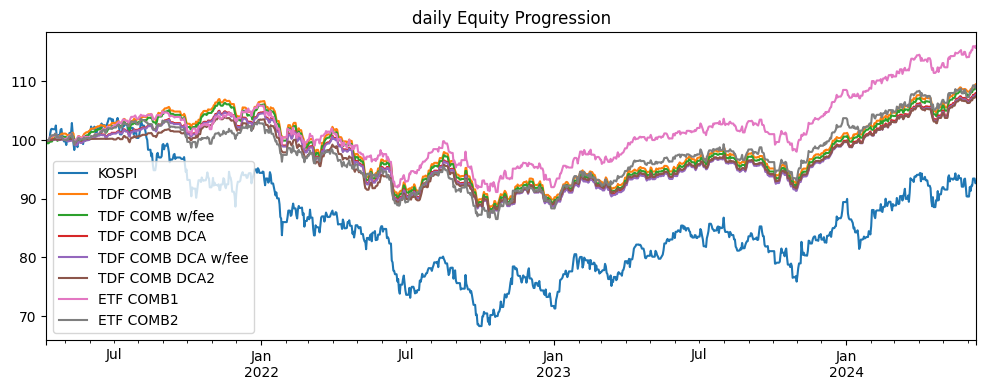

In [115]:
bts.run(figsize=(12,4))

,KOSPI,TDF COMB,TDF COMB w/fee,TDF COMB DCA,TDF COMB DCA w/fee,TDF COMB DCA2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.089502,0.080366,0.077757,0.075071
cagr,-0.02327,0.029135,0.027359,0.024638,0.023858,0.023054
max_drawdown,-0.342102,-0.174055,-0.174059,-0.166899,-0.167251,-0.158577
avg_drawdown,-0.085707,-0.016229,-0.016504,-0.016196,-0.014564,-0.011319
avg_drawdown_days,229.0,56.210526,56.578947,63.235294,56.842105,48.363636
daily_vol,0.136883,0.052665,0.052722,0.050338,0.050339,0.046337
daily_sharpe,-0.050308,0.402564,0.379586,0.358775,0.348333,0.362538
daily_sortino,-0.079776,0.611235,0.576085,0.545526,0.529736,0.556782


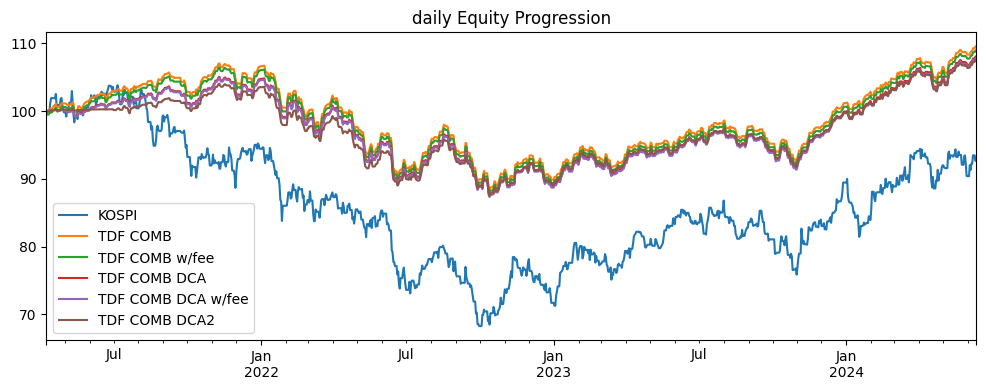

In [70]:
bts.run(range(6), figsize=(12,4))

In [71]:
{i:x for i,x in enumerate(bts.portfolios.keys())}

{0: 'KOSPI',
 1: 'TDF COMB',
 2: 'TDF COMB w/fee',
 3: 'TDF COMB DCA',
 4: 'TDF COMB DCA w/fee',
 5: 'TDF COMB DCA2',
 6: 'ETF COMB1',
 7: 'ETF COMB2'}

,KOSPI,TDF COMB,TDF COMB DCA,TDF COMB DCA2,ETF COMB1,ETF COMB2
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,-0.07205,0.095495,0.080366,0.075071,0.160406,0.091834
cagr,-0.02327,0.029135,0.024638,0.023054,0.047958,0.02805
max_drawdown,-0.342102,-0.174055,-0.166899,-0.158577,-0.141659,-0.16493
avg_drawdown,-0.085707,-0.016229,-0.016196,-0.011319,-0.01141,-0.013601
avg_drawdown_days,229.0,56.210526,63.235294,48.363636,34.129032,43.48
daily_vol,0.136883,0.052665,0.050338,0.046337,0.06132,0.063515
daily_sharpe,-0.050308,0.402564,0.358775,0.362538,0.557741,0.332261
daily_sortino,-0.079776,0.611235,0.545526,0.556782,0.867468,0.51778


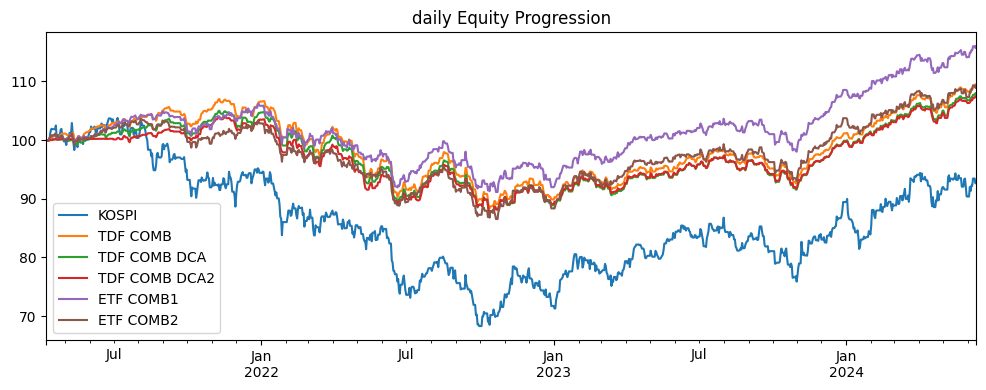

In [72]:
bts.run([0,1,3,5,6,7], figsize=(12,4))

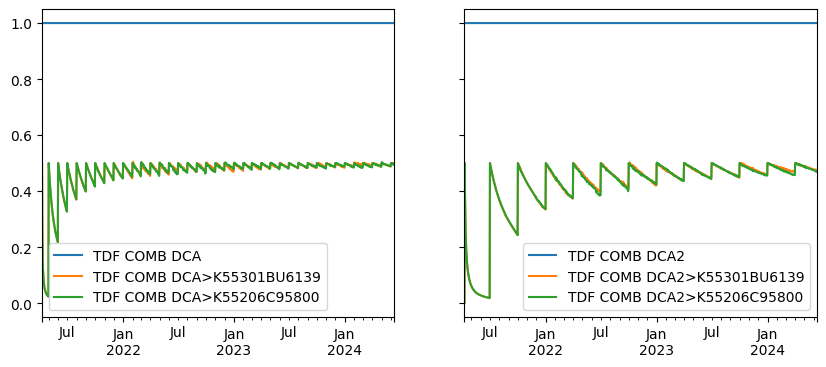

In [34]:
bts.plot_weights([2,3], figsize=(10,4))

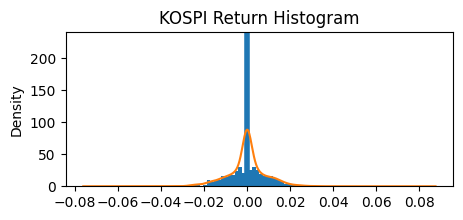

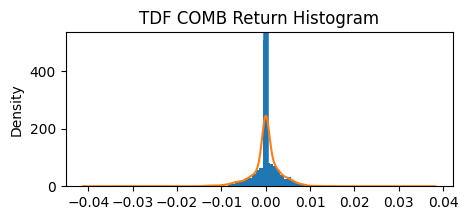

In [35]:
bts.plot_histogram([0,1], bins=50, figsize=(5,2))

# Scaled

## Data

In [45]:
etfs = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [46]:
get_date_range(df_etfs[etfs])

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
273130,2017-06-29,2024-06-11
379800,2021-04-09,2024-06-11


In [47]:
start_date = '2017-06-29'

In [48]:
df_snp = fdr.DataReader('S&P500')
df_snp = df_snp['Adj Close']
df_rate = df_snp/df_snp[0]-1
df_rate

Date
1980-01-02     0.000000
1980-01-03    -0.005106
1980-01-04     0.007186
1980-01-07     0.009928
1980-01-08     0.030163
                ...    
2024-06-11    49.825640
2024-06-12    50.257845
2024-06-13    50.378027
2024-06-14    50.357791
2024-06-17    50.290846
Name: Adj Close, Length: 11209, dtype: float64

In [49]:
df_379800 = df_etfs['379800'].dropna()
df_379800.head()
#df_379800.tail()

Date
2021-04-09    10085.0
2021-04-12    10155.0
2021-04-13    10190.0
2021-04-14    10145.0
2021-04-15    10130.0
Name: 379800, dtype: float64

In [50]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')
df_info.iloc[-1]

name            KODEX 미국S&P500TR assumed from S&P500 rate of r...
ticker                                                   379800_R
commission                                                    0.0
data_type                                                      -1
file                                                     379800_R
check1_date                                            2024-06-11
check1_price                                              16770.0
check2_date                                            2021-04-09
check2_price                                              10085.0
Name: 5, dtype: object

In [51]:
data = df_info.iloc[-1]
df_379800r = convert_rate_to_price(data, rate_is_percent=False, df_rate=df_rate)
df_379800r

error: 27.73 %


date
1980-01-02      329.951573
1980-01-03      328.266871
1980-01-04      332.322617
1980-01-07      333.227366
1980-01-08      339.903766
                  ...     
2024-06-11    16770.000000
2024-06-12    16912.606593
2024-06-13    16952.260834
2024-06-14    16945.584007
2024-06-17    16923.495478
Name: 379800_R, Length: 11209, dtype: float64

<Axes: xlabel='Date'>

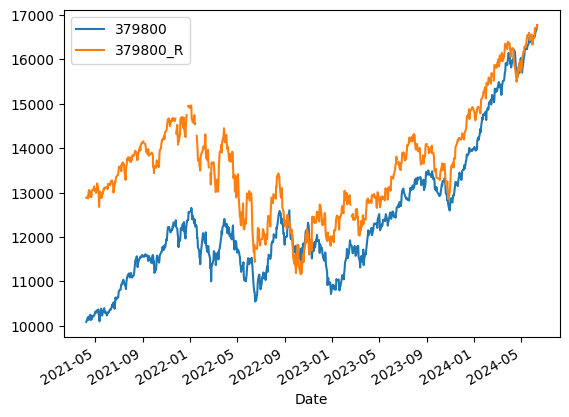

In [52]:
df_379800.to_frame().join(df_379800r).plot()

In [53]:
etfs = ['069500', '273130', '148070']
df = df_etfs[etfs].join(df_379800r).loc[start_date:]
df

,069500,273130,148070,379800_R
Date,,,,
2017-06-29,27193,99855.0,106044.0,7549.014665
2017-06-30,27109,99810.0,105817.0,7560.589054
2017-07-03,27170,99745.0,105613.0,7578.060320
2017-07-04,27002,99655.0,105190.0,NaN
2017-07-05,27105,99620.0,105253.0,7589.073356
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16507.998052
2024-06-05,36755,110820.0,112200.0,16703.579031
2024-06-07,37240,111075.0,112610.0,16681.616938


In [54]:
ticker = '379800_R'
etf_names.update({ticker:'KODEX 미국S&P500TR assumed from S&P500 rate of return'})
etfs.append(ticker)

## Backtest

In [55]:
bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=etf_names, commissions=None)

backtest period reset: 2017-06-29 ~ 2024-06-11
rate of nan filled forward::
  069500: 0.000
  273130: 0.000
  148070: 0.000
  379800_R: 0.033


In [56]:
name = 'KOSPI'
ticker = '069500'
bts.buy_n_hold(ticker, name=name)

In [57]:
{x:etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800_R': 'KODEX 미국S&P500TR assumed from S&P500 rate of return'}

In [58]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [59]:
name = 'ETF COMB1 (M)'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='M', capital_flow=1000000)

In [60]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

,KOSPI,ETF COMB1,ETF COMB1 (M),ETF COMB2
start,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.359183,0.450954,0.430813,0.383078
cagr,0.045118,0.054983,0.052865,0.04774
max_drawdown,-0.380162,-0.189178,-0.190569,-0.20192
avg_drawdown,-0.047992,-0.012449,-0.012622,-0.015412
avg_drawdown_days,94.576923,26.809524,27.47561,39.288136
daily_vol,0.184222,0.078006,0.078233,0.077309
daily_sharpe,0.337775,0.743129,0.714828,0.657651
daily_sortino,0.555855,1.165093,1.118762,1.04768


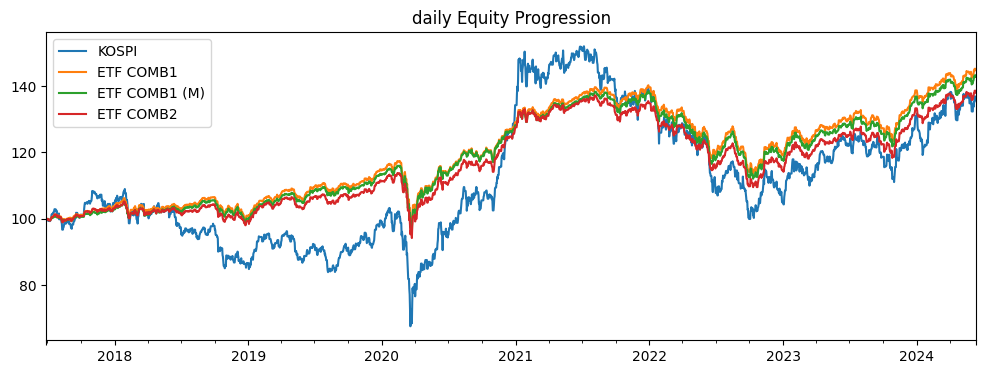

In [61]:
bts.run(figsize=(12,4))

In [82]:
bts.show_weights('ETF COMB1')

KODEX 200                                              0.2
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.3
dtype: float64

In [83]:
bts.show_weights('ETF COMB2')

KODEX 200                                              0.3
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.2
dtype: float64

# Bayesian

## Portfolios

In [13]:
{x:equity_names[x] for x in df_etfs.columns}

{'273130': 'KODEX 종합채권(AA-이상)액티브',
 '453850': 'ACE 미국30년국채액티브(H)',
 '284430': 'KODEX 200미국채혼합',
 '069500': 'KODEX 200',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)'}

In [14]:
name = 'KOSPI'
tickers = ['069500']
weights = [1]

pfs = list()
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)

[equity_names[x] for x in df_etfs[tickers].columns]

['KODEX 200']

In [15]:
{x: equity_names[x] for x in df_tdfs.columns}

{'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)'}

In [16]:
name = 'TDF COMB'
tickers = ['K55301BU6139', 'K55206C95800']
weights = [0.5, 0.5]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[equity_names[x] for x in df_tdfs[tickers].columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

In [17]:
tickers = ['K55301BU6139']
name = tickers[0]
weights = [1]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[equity_names[x] for x in df_tdfs[tickers].columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e']

In [18]:
tickers = ['K55206C95800']
name = tickers[0]
weights = [1]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[equity_names[x] for x in df_tdfs[tickers].columns]

['키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

## Backtest

In [19]:
df = df_etfs.join(df_tdfs, how='outer')

bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               equity_names=etf_names, commissions=None)

In [20]:
bts.build_batch(pfs, freq='Y', fill_na=False, reset_portfolios=True)

period reset: 2002-10-14 ~ 2024-06-11
ratio of nan dropped::
  069500: 0.153
period reset: 2018-07-26 ~ 2024-06-13
ratio of nan dropped::
  K55301BU6139: 0.000
  K55206C95800: 0.478
period reset: 2017-09-20 ~ 2024-06-16
ratio of nan dropped::
  K55301BU6139: 0.000
period reset: 2018-07-26 ~ 2024-06-13
ratio of nan dropped::
  K55206C95800: 0.478


,KOSPI,TDF COMB,K55301BU6139,K55206C95800
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.416803,0.419821,0.501756,0.346793
cagr,0.061033,0.061417,0.071592,0.051929
max_drawdown,-0.346464,-0.215628,-0.215087,-0.219971
avg_drawdown,-0.052969,-0.016192,-0.014093,-0.017237
avg_drawdown_days,82.2,34.333333,27.171429,34.690909
daily_vol,0.193239,0.070285,0.094036,0.090421
daily_sharpe,0.410894,0.905076,0.801393,0.619546
daily_sortino,0.684742,1.364063,1.209366,0.958091


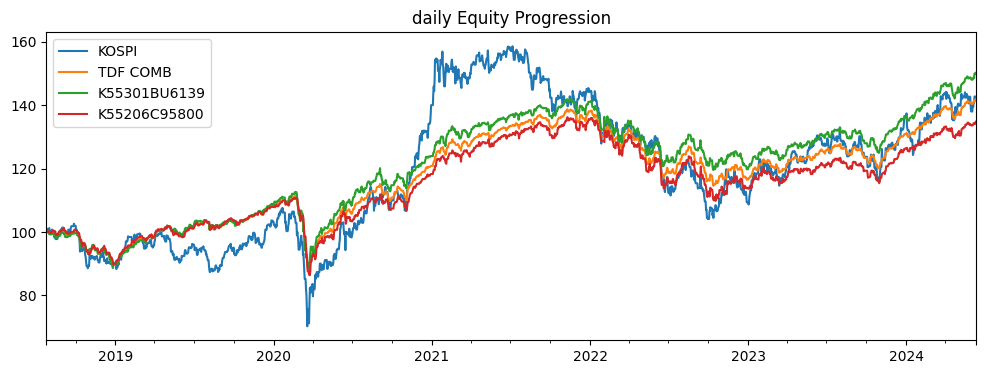

In [21]:
bts.run(figsize=(12,4))

In [22]:
df_bts = bts.get_historical()
df_bts.head()

,KOSPI,TDF COMB,K55301BU6139,K55206C95800
2002-10-14,100.000000,NaN,NaN,NaN
2002-10-15,102.469152,NaN,NaN,NaN
2002-10-16,102.912827,NaN,NaN,NaN
2002-10-17,104.359596,NaN,NaN,NaN
2002-10-18,108.834933,NaN,NaN,NaN


## Estimate

In [23]:
df = df_bts[['KOSPI', 'TDF COMB']]
ae = AssetEvaluator(df)

TDF COMB: 240


In [24]:
ae.summary(freq='yearly')

,KOSPI,TDF COMB
years,21.2,5.7
cagr,0.09689,0.063628
yearly_mean,0.114486,0.068969
yearly_vol,0.222652,0.118083
yearly_sharpe,0.514193,0.584076


In [26]:
ae.bayesian_sample(freq='yearly')

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:08

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [27]:
var_names = ['_mean', '_vol']
ae.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yearly_mean[KOSPI],0.110,0.003,0.104,0.116,0.0,0.0,4199.0,3146.0,1.0
yearly_mean[TDF COMB],0.068,0.003,0.062,0.075,0.0,0.0,4644.0,3114.0,1.0
yearly_vol[KOSPI],0.212,0.003,0.206,0.218,0.0,0.0,2944.0,3094.0,1.0
yearly_vol[TDF COMB],0.114,0.003,0.109,0.119,0.0,0.0,3889.0,2890.0,1.0


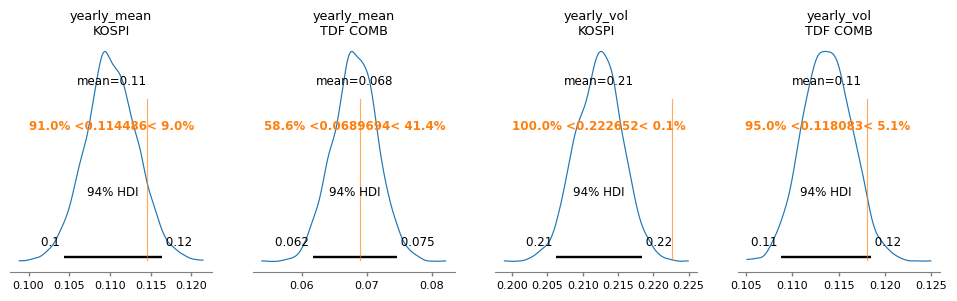

In [29]:
ae.bayesian_plot(var_names, figsize=(12,3), textsize=8)

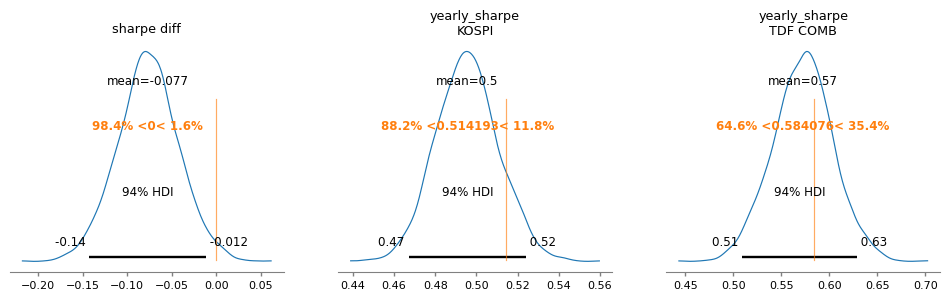

In [30]:
var_names = 'sharpe'
ae.bayesian_plot(var_names, figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:05

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


period reset: 2018-07-26 ~ 2024-06-11
ratio of nan filled forward::
  KOSPI: 0.000
  TDF COMB: 0.001


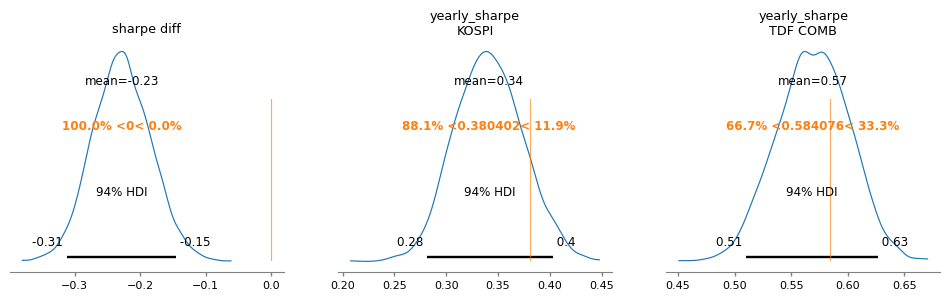

In [31]:
ae.bayesian_sample(freq='yearly', align_period=True)
ae.bayesian_plot(var_names, figsize=(12,3), textsize=8)

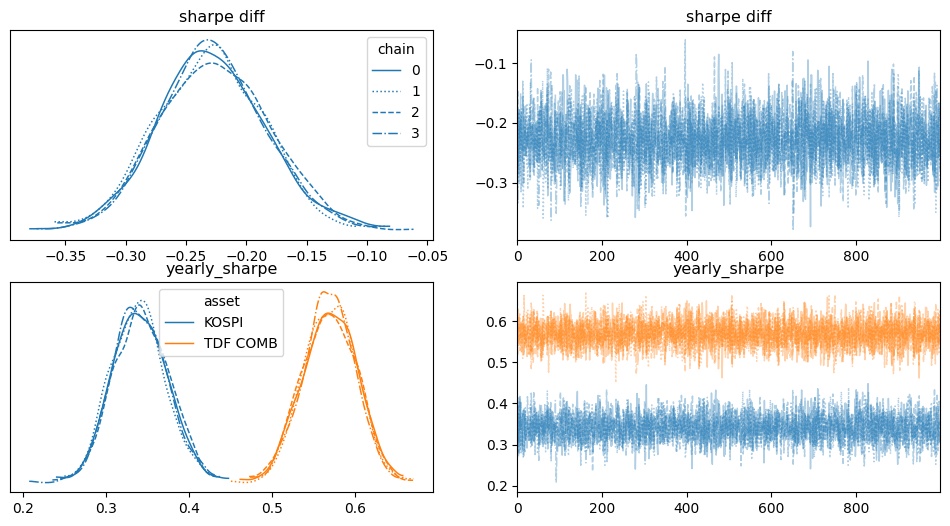

In [32]:
_ = ae.plot_trace(var_names=var_names, legend=True)

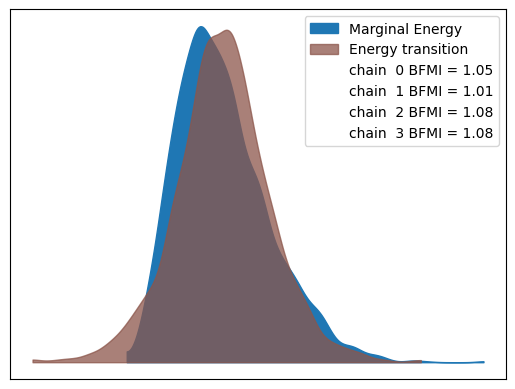

In [33]:
_ = ae.plot_energy()

### Annulize Test

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:10

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


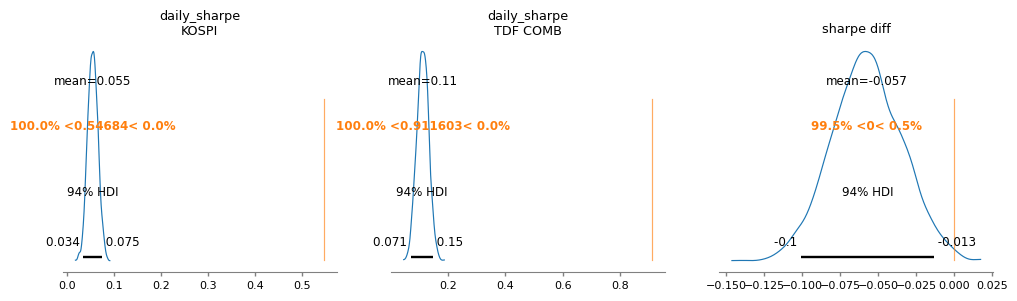

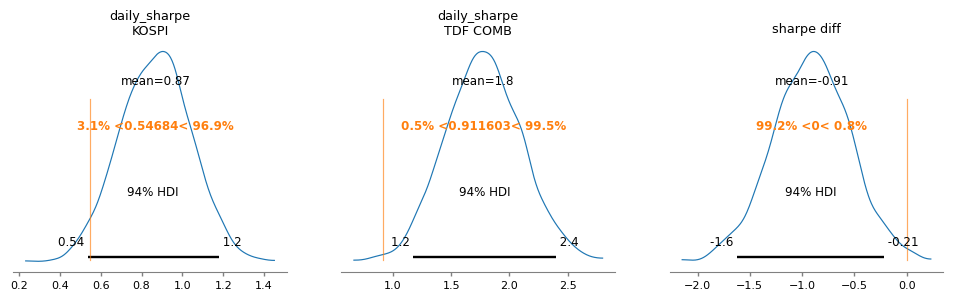

In [34]:
freq='daily'
annualize = True
for debug_annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize, debug_annualize=debug_annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:15

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


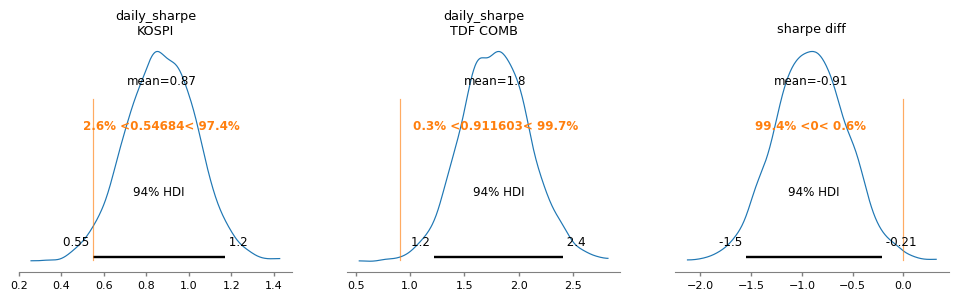

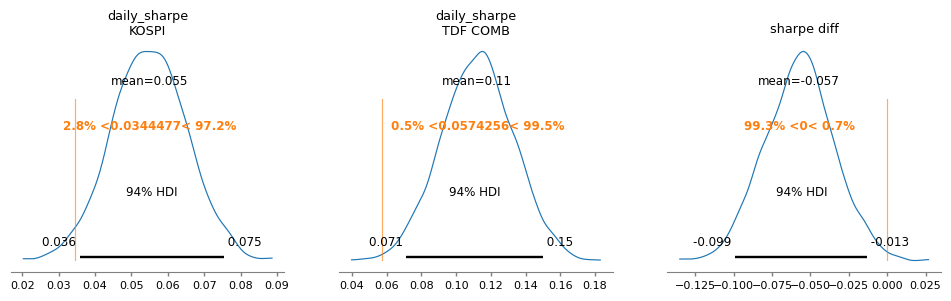

In [261]:
freq='daily'
for annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:18

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


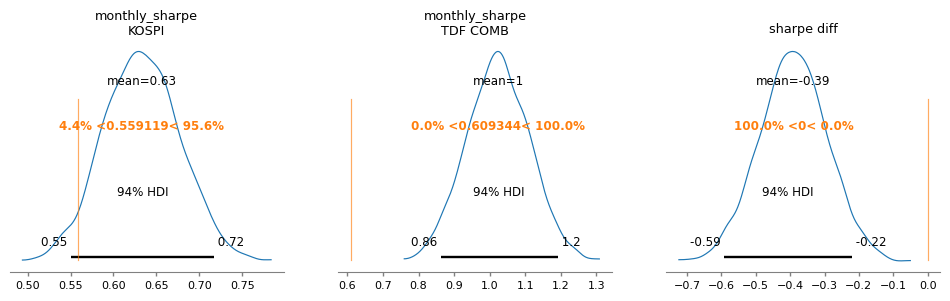

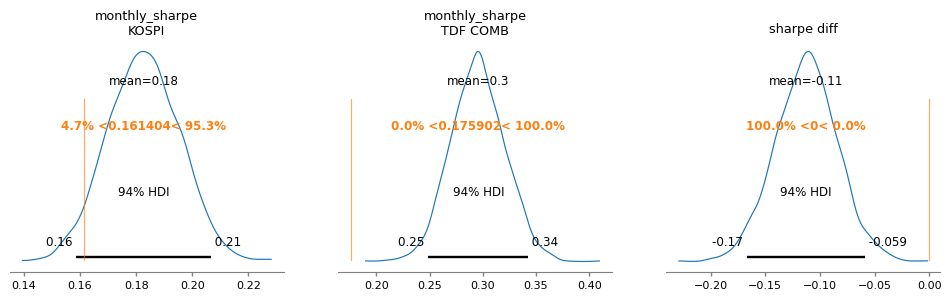

In [262]:
freq='monthly'
for annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


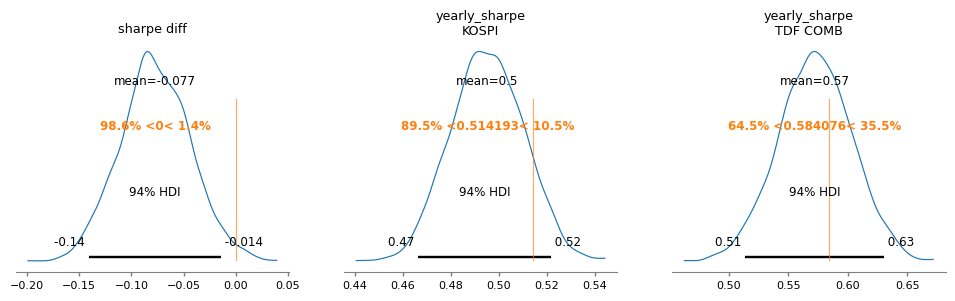

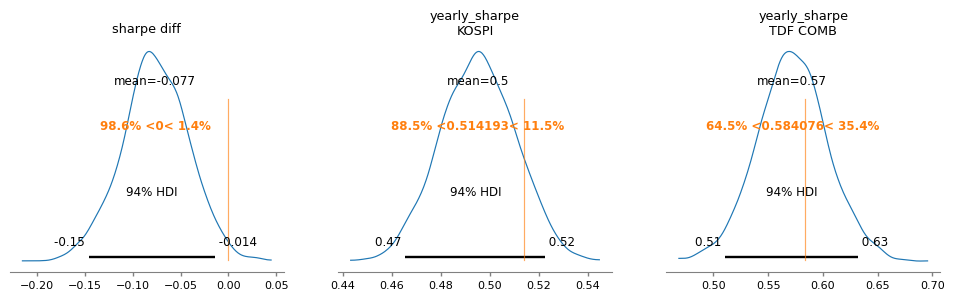

In [263]:
freq='yearly'
for annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)